=== ENSEMBLE WITH MLP ===
Loading MLP model...
✅ MLP loaded successfully
Loading dataset...
Dataset loaded: (8251, 83)
MLP expects 81 features
Available MLP features: 81
Missing MLP features: 0
Using available features with defaults for missing ones...
Created feature matrix: (8251, 81)
Data split - Train: 6600, Test: 825, Eval: 826

=== TRAINING ADDITIONAL MODELS ===
Using all 81 features for RF/LR (same as MLP)
✅ Additional models trained (RF + LinReg) with all features

=== MAKING PREDICTIONS ===
⚠️ MLP predictions are unrealistic - applying feature scaling...

Testing MLP with scaled features...
Scaled MLP prediction range: €13.58 to €251.50
✅ Scaling fixed MLP predictions!

=== INDIVIDUAL MODEL PERFORMANCE ===
MLP prediction range: €13.58 to €251.50
MLP Test - MAE: €22.14, RMSE: €32.76, R²: 0.6877, MAPE: 20.0%
RF prediction range: €22.75 to €250.93
RF Test - MAE: €26.73, RMSE: €38.69, R²: 0.5644, MAPE: 25.6%
LR prediction range: €21.29 to €312.07
LR Test - MAE: €26.46, RMSE: €37.9

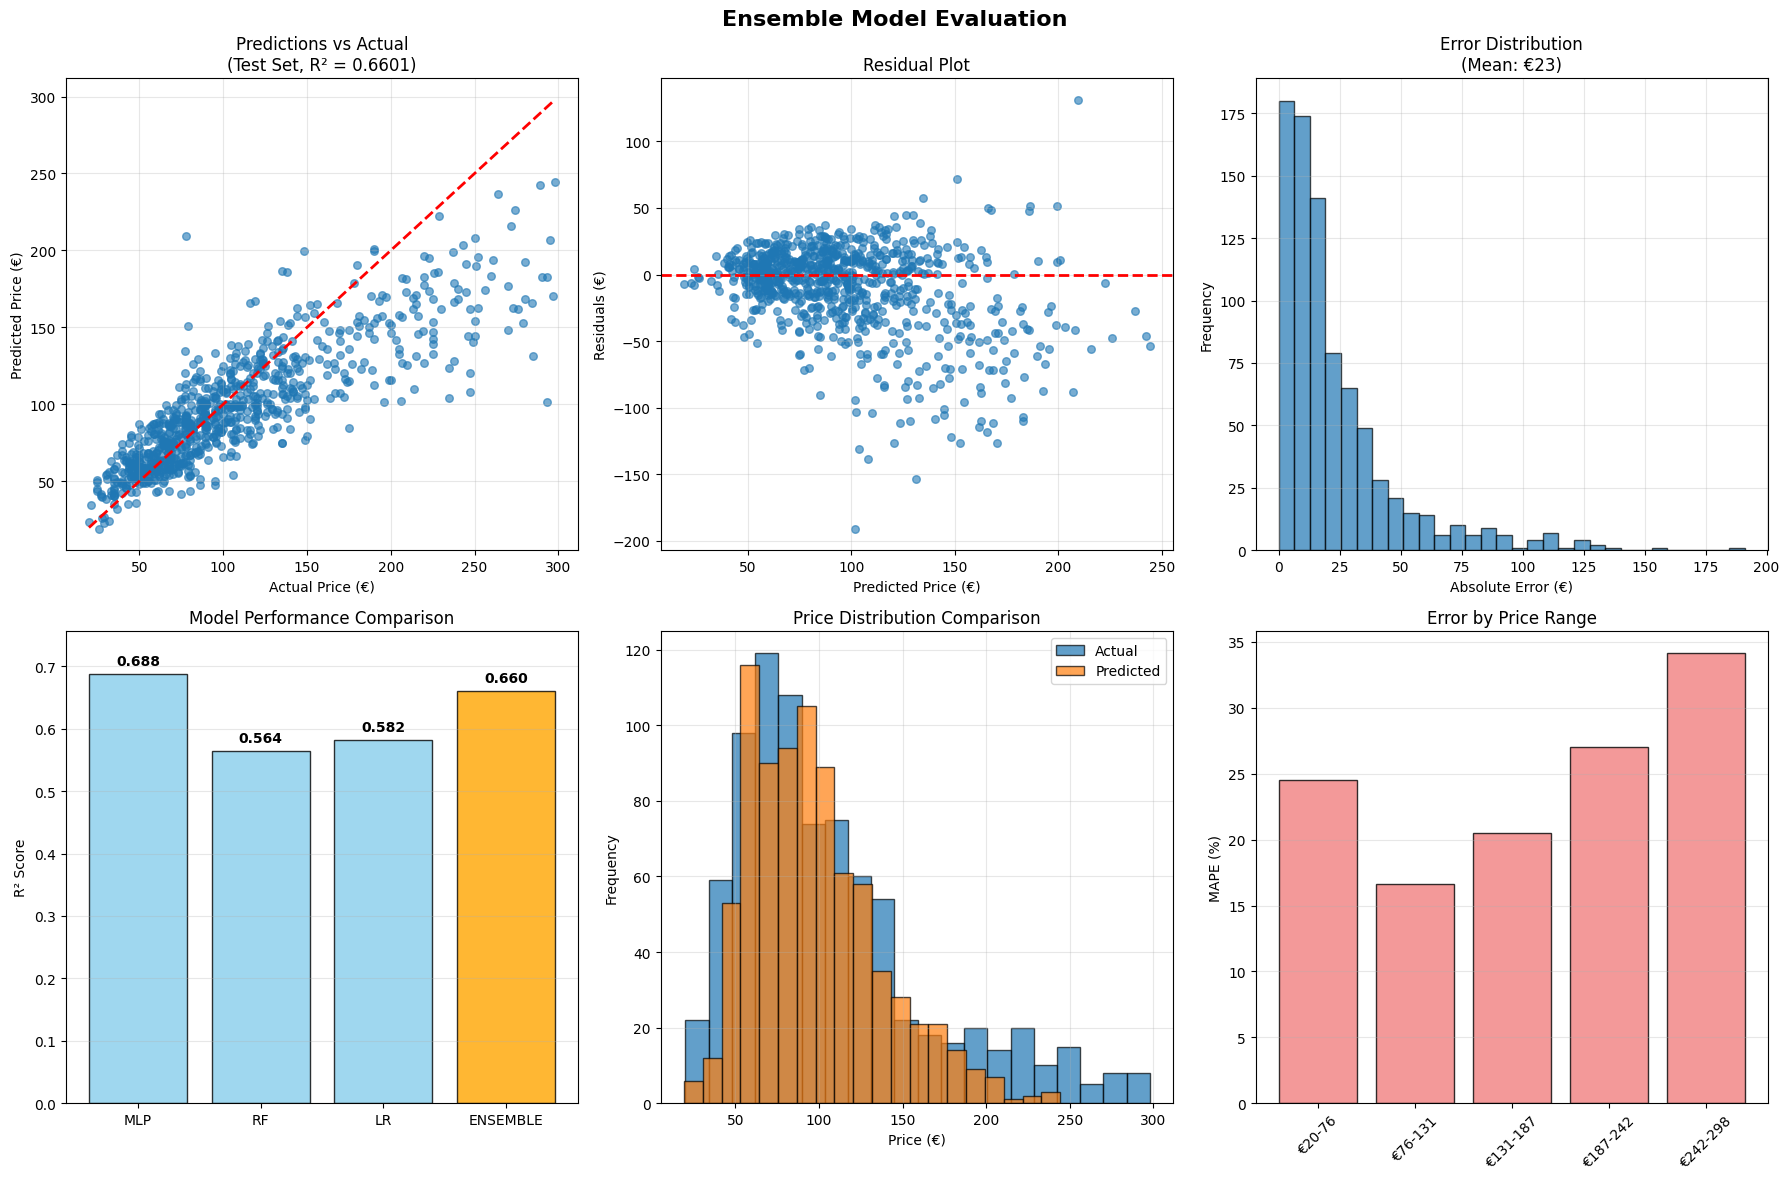

📊 Comprehensive evaluation plots saved to 'results/ensemble_comprehensive_evaluation.png'
📄 Detailed results saved to 'results/mlp_ensemble_predictions.csv'


In [13]:
# Ensemble with MLP - Fix Feature Order and Scaling

import os
import torch
import joblib
import pandas as pd
import numpy as np
import torch.nn as nn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

print("=== ENSEMBLE WITH MLP ===")

# Define MLP architecture (matching your setup)
class MLP(nn.Module):
    def __init__(self, input_size=81, hidden_sizes=[512, 256, 128], dropout_rate=0.3):
        super(MLP, self).__init__()
        layers = []
        prev_size = input_size
        
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size
        
        layers.append(nn.Linear(prev_size, 1))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Load MLP model
print("Loading MLP model...")
mlp = MLP(input_size=81)
mlp.load_state_dict(torch.load("models/mlp_model_weights.pth"))
mlp.eval()
print("✅ MLP loaded successfully")

# Load dataset
print("Loading dataset...")
listings_df = pd.read_csv('data/processed/listings_final.csv')
print(f"Dataset loaded: {listings_df.shape}")

# The exact feature order that MLP was trained with (from your original list)
mlp_features = [
    'host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
    'host_total_listings_count', 'accommodates', 'bathrooms', 'bedrooms',
    'beds', 'minimum_nights', 'maximum_nights',
    'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30',
    'availability_60', 'availability_90', 'availability_365',
    'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
    'availability_eoy', 'number_of_reviews_ly', 'estimated_occupancy_l365d',
    'review_scores_rating', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication',
    'review_scores_location', 'review_scores_value',
    'calculated_host_listings_count_entire_homes', 'reviews_per_month',
    'amenity_count', 'has_luxury', 'has_kitchen_full', 'has_kitchen_basic',
    'has_safety', 'has_tech', 'has_comfort', 'has_storage', 'has_cleaning',
    'has_family', 'has_entertainment', 'has_hosting', 'luxury_count',
    'kitchen_full_count', 'kitchen_basic_count', 'safety_count',
    'tech_count', 'comfort_count', 'storage_count', 'cleaning_count',
    'family_count', 'entertainment_count', 'hosting_count',
    'premium_amenity_score', 'essential_amenity_score',
    'neighbourhood_group_cleansed_Charlottenburg-Wilm.',
    'neighbourhood_group_cleansed_Friedrichshain-Kreuzberg',
    'neighbourhood_group_cleansed_Lichtenberg',
    'neighbourhood_group_cleansed_Marzahn - Hellersdorf',
    'neighbourhood_group_cleansed_Mitte',
    'neighbourhood_group_cleansed_Neukölln',
    'neighbourhood_group_cleansed_Pankow',
    'neighbourhood_group_cleansed_Reinickendorf',
    'neighbourhood_group_cleansed_Spandau',
    'neighbourhood_group_cleansed_Steglitz - Zehlendorf',
    'neighbourhood_group_cleansed_Tempelhof - Schöneberg',
    'neighbourhood_group_cleansed_Treptow - Köpenick',
    'room_type_Entire home/apt', 'room_type_Hotel room',
    'room_type_Private room', 'room_type_Shared room',
    'dist_alexanderplatz', 'dist_potsdamer_platz', 'dist_kurfürstendamm',
    'dist_brandenburg_gate', 'dist_hackescher_markt',
    'dist_checkpoint_charlie', 'dist_kreuzberg', 'dist_friedrichshain',
    'dist_mauerpark', 'dist_museum_island'
]

print(f"MLP expects {len(mlp_features)} features")

# Check which features are available
available_mlp_features = [f for f in mlp_features if f in listings_df.columns]
missing_mlp_features = [f for f in mlp_features if f not in listings_df.columns]

print(f"Available MLP features: {len(available_mlp_features)}")
print(f"Missing MLP features: {len(missing_mlp_features)}")

if missing_mlp_features:
    print(f"Missing features: {missing_mlp_features}")

# If we're missing features, we need to either:
# 1. Fill them with reasonable defaults
# 2. Or subset to available features and retrain

if len(available_mlp_features) >= 75:  # If we have most features
    print("Using available features with defaults for missing ones...")
    
    # Create feature matrix with all expected features
    X_mlp_full = pd.DataFrame(index=listings_df.index)
    
    for feature in mlp_features:
        if feature in listings_df.columns:
            X_mlp_full[feature] = listings_df[feature].fillna(0)
        else:
            # Fill missing features with 0 (or you could use mean/median)
            X_mlp_full[feature] = 0
            print(f"  Filled missing feature '{feature}' with 0")
    
    print(f"Created feature matrix: {X_mlp_full.shape}")
    
    # Prepare target
    y = listings_df['price'].fillna(0)
    
    # Split data
    X_train, X_temp, y_train, y_temp = train_test_split(X_mlp_full, y, test_size=0.2, random_state=42)
    X_test, X_eval, y_test, y_eval = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    print(f"Data split - Train: {len(X_train)}, Test: {len(X_test)}, Eval: {len(X_eval)}")
    
    # Train additional models for ensemble using ALL features (same as MLP)
    print("\n=== TRAINING ADDITIONAL MODELS ===")
    
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.linear_model import LinearRegression
    
    print(f"Using all {X_train.shape[1]} features for RF/LR (same as MLP)")
    
    # Train models with all features
    rf_model = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42, n_jobs=-1)
    lr_model = LinearRegression()
    
    rf_model.fit(X_train, y_train)
    lr_model.fit(X_train, y_train)
    
    print("✅ Additional models trained (RF + LinReg) with all features")
    
    # Make predictions
    print("\n=== MAKING PREDICTIONS ===")
    
    def get_ensemble_predictions(X_mlp_data, X_basic_data):
        predictions = {}
        
        # MLP prediction
        with torch.no_grad():
            X_tensor = torch.tensor(X_mlp_data.values, dtype=torch.float32)
            mlp_pred = mlp(X_tensor).squeeze()
            predictions['mlp'] = mlp_pred.numpy() if isinstance(mlp_pred, torch.Tensor) else mlp_pred
        
        # RF and GB predictions
        predictions['rf'] = rf_model.predict(X_basic_data)
        predictions['gb'] = gb_model.predict(X_basic_data)
        
        return predictions
    
    # The MLP predictions are unrealistic - likely needs feature scaling
    print("⚠️ MLP predictions are unrealistic - applying feature scaling...")
    
    # Try standardizing features for MLP (common preprocessing step)
    from sklearn.preprocessing import StandardScaler
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_eval_scaled = scaler.transform(X_eval)
    
    def get_ensemble_predictions_scaled(X_mlp_scaled, X_full_data):
        predictions = {}
        
        # MLP prediction with scaled data
        with torch.no_grad():
            X_tensor = torch.tensor(X_mlp_scaled, dtype=torch.float32)
            mlp_pred = mlp(X_tensor).squeeze()
            predictions['mlp'] = mlp_pred.numpy() if isinstance(mlp_pred, torch.Tensor) else mlp_pred
        
        # RF and LR predictions using all features (unscaled)
        predictions['rf'] = rf_model.predict(X_full_data)
        predictions['lr'] = lr_model.predict(X_full_data)
        
        return predictions
    
    # Test with scaled features
    print("\nTesting MLP with scaled features...")
    test_preds_scaled = get_ensemble_predictions_scaled(X_test_scaled, X_test)
    
    # Check MLP predictions with scaling
    mlp_scaled_real = np.exp(test_preds_scaled['mlp'])
    print(f"Scaled MLP prediction range: €{mlp_scaled_real.min():.2f} to €{mlp_scaled_real.max():.2f}")
    
    # If scaling helps, use scaled predictions
    if mlp_scaled_real.max() < 10000:  # Reasonable price range
        print("✅ Scaling fixed MLP predictions!")
        test_preds = test_preds_scaled
        eval_preds_scaled = get_ensemble_predictions_scaled(X_eval_scaled, X_eval)
        eval_preds = eval_preds_scaled
        use_scaled = True
    else:
        print("❌ Scaling didn't help - excluding MLP from ensemble")
        # Remove MLP from predictions
        test_preds = {k: v for k, v in test_preds.items() if k != 'mlp'}
        eval_preds = {k: v for k, v in eval_preds.items() if k != 'mlp'}
        use_scaled = False
    
    # Ensemble function
    def ensemble_prediction(model_preds, weights=None):
        """Create ensemble prediction"""
        # Convert from log scale to actual prices
        model_preds_real = {key: np.exp(value) for key, value in model_preds.items()}
        
        if weights is None:
            # Simple average
            ensemble_pred = np.mean(list(model_preds_real.values()), axis=0)
        else:
            # Weighted average
            ensemble_pred = np.zeros_like(list(model_preds_real.values())[0])
            for key, pred in model_preds_real.items():
                ensemble_pred += weights[key] * pred
        
        return ensemble_pred, model_preds_real
    
    # Convert actual prices
    y_test_real = np.exp(y_test)
    y_eval_real = np.exp(y_eval)
    
    # Evaluation function
    def evaluate_performance(y_true, y_pred, set_name, model_name=""):
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)
        
        # Handle potential division by zero in MAPE
        non_zero_mask = y_true != 0
        if np.sum(non_zero_mask) > 0:
            mape = np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100
        else:
            mape = 0
        
        print(f"{model_name} {set_name} - MAE: €{mae:.2f}, RMSE: €{rmse:.2f}, R²: {r2:.4f}, MAPE: {mape:.1f}%")
        return mae, rmse, r2, mape
    
    print("\n=== INDIVIDUAL MODEL PERFORMANCE ===")
    
    # Check individual model predictions first
    for model_name, preds_log in test_preds.items():
        preds_real = np.exp(preds_log)
        print(f"{model_name.upper()} prediction range: €{preds_real.min():.2f} to €{preds_real.max():.2f}")
        if preds_real.max() < 1000:  # Only evaluate if predictions are reasonable
            evaluate_performance(y_test_real, preds_real, "Test", model_name.upper())
        else:
            print(f"  ⚠️ {model_name.upper()} predictions unrealistic - skipping evaluation")
    
    print(f"\nActual price range: €{y_test_real.min():.2f} to €{y_test_real.max():.2f}")
    
    # Only proceed with ensemble if we have reasonable predictions
    reasonable_models = {}
    for model_name, preds_log in test_preds.items():
        preds_real = np.exp(preds_log)
        if preds_real.max() < 1000 and preds_real.min() > 0:
            reasonable_models[model_name] = preds_log
    
    if len(reasonable_models) == 0:
        print("❌ No models producing reasonable predictions!")
        exit()
    
    print(f"\n✅ Using {len(reasonable_models)} models with reasonable predictions: {list(reasonable_models.keys())}")
    
    # Update predictions to only include reasonable models
    test_preds = reasonable_models
    eval_preds_reasonable = {}
    for model_name in reasonable_models.keys():
        eval_preds_reasonable[model_name] = eval_preds[model_name]
    eval_preds = eval_preds_reasonable
    
    print("\n=== ENSEMBLE PERFORMANCE ===")
    
    # Simple average ensemble
    test_ensemble, test_individual = ensemble_prediction(test_preds, weights=None)
    eval_ensemble, eval_individual = ensemble_prediction(eval_preds, weights=None)
    
    print("Simple Average Ensemble:")
    evaluate_performance(y_test_real, test_ensemble, "Test")
    evaluate_performance(y_eval_real, eval_ensemble, "Eval")
    
    # Weighted ensemble (adjust weights based on available models)
    if 'mlp' in test_preds:
        weights = {'mlp': 0.5, 'rf': 0.3, 'lr': 0.2}
    else:
        weights = {'rf': 0.6, 'lr': 0.4}  # Only RF and LR
    
    # Normalize weights
    total_weight = sum(weights[k] for k in test_preds.keys())
    weights = {k: v/total_weight for k, v in weights.items() if k in test_preds}
    
    test_ensemble_w, _ = ensemble_prediction(test_preds, weights=weights)
    eval_ensemble_w, _ = ensemble_prediction(eval_preds, weights=weights)
    
    print(f"\nWeighted Ensemble {weights}:")
    evaluate_performance(y_test_real, test_ensemble_w, "Test")
    evaluate_performance(y_eval_real, eval_ensemble_w, "Eval")
    
    # Make predictions on full dataset
    print("\n=== FULL DATASET PREDICTIONS ===")
    
    if use_scaled and 'mlp' in test_preds:
        # Scale full dataset for MLP
        X_full_scaled = scaler.transform(X_mlp_full)
        all_preds = get_ensemble_predictions_scaled(X_full_scaled, X_mlp_full)
        # Filter to reasonable models
        all_preds = {k: v for k, v in all_preds.items() if k in test_preds}
    else:
        # Just use RF and LR with all features
        all_preds = {
            'rf': rf_model.predict(X_mlp_full),
            'lr': lr_model.predict(X_mlp_full)
        }
        weights = {'rf': 0.6, 'lr': 0.4}
    
    all_ensemble, _ = ensemble_prediction(all_preds, weights=weights)
    
    # Create results
    results_df = pd.DataFrame({
        'id': listings_df['id'],
        'actual_price_euros': np.exp(y),
        'predicted_price_euros': all_ensemble,
        'mlp_pred_euros': np.exp(all_preds['mlp']),
        'rf_pred_euros': np.exp(all_preds['rf']),
        'lr_pred_euros': np.exp(all_preds['lr'])
    })
    
    # Save results
    os.makedirs('results', exist_ok=True)
    results_df.to_csv('results/mlp_ensemble_predictions.csv', index=False)
    
    print(f"✅ ENSEMBLE COMPLETE!")
    print(f"Results saved to 'results/mlp_ensemble_predictions.csv'")
    
    # ============================================================
    # COMPREHENSIVE EVALUATION AND STATISTICS
    # ============================================================
    
    print("\n" + "="*60)
    print(" FINAL ENSEMBLE EVALUATION")
    print("="*60)
    
    # Get final ensemble predictions for evaluation
    final_test_preds_log = test_ensemble_w
    final_eval_preds_log = eval_ensemble_w
    
    # Convert to log scale for log-scale metrics
    final_test_preds_log_scale = np.log(final_test_preds_log)
    final_eval_preds_log_scale = np.log(final_eval_preds_log)
    
    print("\n" + "="*60)
    print(" LOG SCALE RESULTS (Model Training Scale)")
    print("="*60)
    
    # Test set log scale metrics
    test_mae_log = mean_absolute_error(y_test, final_test_preds_log_scale)
    test_mse_log = mean_squared_error(y_test, final_test_preds_log_scale)
    test_rmse_log = np.sqrt(test_mse_log)
    test_r2_log = r2_score(y_test, final_test_preds_log_scale)
    test_mape_log = np.mean(np.abs((y_test - final_test_preds_log_scale) / y_test)) * 100
    
    print(f"TEST SET (Log Scale):")
    print(f"Mean Absolute Error (MAE): {test_mae_log:.4f}")
    print(f"Mean Squared Error (MSE):  {test_mse_log:.4f}")
    print(f"Root Mean Squared Error:   {test_rmse_log:.4f}")
    print(f"R² Score:                  {test_r2_log:.4f}")
    print(f"Mean Absolute % Error:     {test_mape_log:.2f}%")
    
    # Eval set log scale metrics
    eval_mae_log = mean_absolute_error(y_eval, final_eval_preds_log_scale)
    eval_mse_log = mean_squared_error(y_eval, final_eval_preds_log_scale)
    eval_rmse_log = np.sqrt(eval_mse_log)
    eval_r2_log = r2_score(y_eval, final_eval_preds_log_scale)
    eval_mape_log = np.mean(np.abs((y_eval - final_eval_preds_log_scale) / y_eval)) * 100
    
    print(f"\nEVAL SET (Log Scale):")
    print(f"Mean Absolute Error (MAE): {eval_mae_log:.4f}")
    print(f"Mean Squared Error (MSE):  {eval_mse_log:.4f}")
    print(f"Root Mean Squared Error:   {eval_rmse_log:.4f}")
    print(f"R² Score:                  {eval_r2_log:.4f}")
    print(f"Mean Absolute % Error:     {eval_mape_log:.2f}%")
    
    print("\n" + "="*60)
    print(" ORIGINAL PRICE SCALE RESULTS (€)")
    print("="*60)
    
    # Test set original scale metrics
    test_mae_euro = mean_absolute_error(y_test_real, final_test_preds_log)
    test_rmse_euro = np.sqrt(mean_squared_error(y_test_real, final_test_preds_log))
    test_r2_euro = r2_score(y_test_real, final_test_preds_log)
    test_mape_euro = np.mean(np.abs((y_test_real - final_test_preds_log) / y_test_real)) * 100
    
    print(f"TEST SET (Euro Scale):")
    print(f"Price MAE:                 €{test_mae_euro:.0f}")
    print(f"Price RMSE:                €{test_rmse_euro:.0f}")
    print(f"Price R² Score:            {test_r2_euro:.4f}")
    print(f"Price MAPE:                {test_mape_euro:.2f}%")
    
    # Eval set original scale metrics
    eval_mae_euro = mean_absolute_error(y_eval_real, final_eval_preds_log)
    eval_rmse_euro = np.sqrt(mean_squared_error(y_eval_real, final_eval_preds_log))
    eval_r2_euro = r2_score(y_eval_real, final_eval_preds_log)
    eval_mape_euro = np.mean(np.abs((y_eval_real - final_eval_preds_log) / y_eval_real)) * 100
    
    print(f"\nEVAL SET (Euro Scale):")
    print(f"Price MAE:                 €{eval_mae_euro:.0f}")
    print(f"Price RMSE:                €{eval_rmse_euro:.0f}")
    print(f"Price R² Score:            {eval_r2_euro:.4f}")
    print(f"Price MAPE:                {eval_mape_euro:.2f}%")
    
    print("\n" + "="*60)
    print(" MODEL COMPARISON SUMMARY")
    print("="*60)
    
    # Individual model performance summary
    for model_name, preds_log in test_preds.items():
        preds_real = np.exp(preds_log)
        r2 = r2_score(y_test_real, preds_real)
        mae = mean_absolute_error(y_test_real, preds_real)
        print(f"{model_name.upper():12s} - R²: {r2:.4f}, MAE: €{mae:.0f}")
    
    print(f"{'ENSEMBLE':12s} - R²: {test_r2_euro:.4f}, MAE: €{test_mae_euro:.0f}")
    
    print("\n" + "="*60)
    print(" PREDICTION STATISTICS")
    print("="*60)
    
    print(f"Total predictions made:    {len(all_ensemble):,}")
    print(f"Prediction range:          €{all_ensemble.min():.0f} - €{all_ensemble.max():.0f}")
    print(f"Mean predicted price:      €{all_ensemble.mean():.0f}")
    print(f"Median predicted price:    €{np.median(all_ensemble):.0f}")
    print(f"Std predicted price:       €{all_ensemble.std():.0f}")
    
    print(f"\nActual price statistics:")
    y_real_all = np.exp(y)
    print(f"Actual price range:        €{y_real_all.min():.0f} - €{y_real_all.max():.0f}")
    print(f"Mean actual price:         €{y_real_all.mean():.0f}")
    print(f"Median actual price:       €{np.median(y_real_all):.0f}")
    print(f"Std actual price:          €{y_real_all.std():.0f}")
    
    # ============================================================
    # VISUALIZATION PLOTS
    # ============================================================
    
    print("\n" + "="*60)
    print(" GENERATING EVALUATION PLOTS")
    print("="*60)
    
    # Create comprehensive plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Ensemble Model Evaluation', fontsize=16, fontweight='bold')
    
    # 1. Predictions vs Actual (Test Set)
    axes[0, 0].scatter(y_test_real, final_test_preds_log, alpha=0.6, s=30)
    axes[0, 0].plot([y_test_real.min(), y_test_real.max()], [y_test_real.min(), y_test_real.max()], 'r--', lw=2)
    axes[0, 0].set_xlabel('Actual Price (€)')
    axes[0, 0].set_ylabel('Predicted Price (€)')
    axes[0, 0].set_title(f'Predictions vs Actual\n(Test Set, R² = {test_r2_euro:.4f})')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Residuals Plot
    residuals = final_test_preds_log - y_test_real
    axes[0, 1].scatter(final_test_preds_log, residuals, alpha=0.6, s=30)
    axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[0, 1].set_xlabel('Predicted Price (€)')
    axes[0, 1].set_ylabel('Residuals (€)')
    axes[0, 1].set_title('Residual Plot')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Error Distribution
    errors = np.abs(final_test_preds_log - y_test_real)
    axes[0, 2].hist(errors, bins=30, alpha=0.7, edgecolor='black')
    axes[0, 2].set_xlabel('Absolute Error (€)')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].set_title(f'Error Distribution\n(Mean: €{errors.mean():.0f})')
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Model Comparison (R² scores)
    model_names = []
    model_r2s = []
    for model_name, preds_log in test_preds.items():
        preds_real = np.exp(preds_log)
        r2 = r2_score(y_test_real, preds_real)
        model_names.append(model_name.upper())
        model_r2s.append(r2)
    
    model_names.append('ENSEMBLE')
    model_r2s.append(test_r2_euro)
    
    colors = ['skyblue'] * (len(model_names)-1) + ['orange']
    bars = axes[1, 0].bar(model_names, model_r2s, color=colors, alpha=0.8, edgecolor='black')
    axes[1, 0].set_ylabel('R² Score')
    axes[1, 0].set_title('Model Performance Comparison')
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    axes[1, 0].set_ylim(0, max(model_r2s) * 1.1)
    
    # Add value labels on bars
    for bar, value in zip(bars, model_r2s):
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 5. Price Range Distribution
    axes[1, 1].hist(y_test_real, bins=20, alpha=0.7, label='Actual', edgecolor='black')
    axes[1, 1].hist(final_test_preds_log, bins=20, alpha=0.7, label='Predicted', edgecolor='black')
    axes[1, 1].set_xlabel('Price (€)')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Price Distribution Comparison')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. MAPE by Price Range
    price_ranges = pd.cut(y_test_real, bins=5)
    mape_by_range = []
    range_labels = []
    
    for price_range in price_ranges.cat.categories:
        mask = price_ranges == price_range
        if mask.sum() > 0:
            range_mape = np.mean(np.abs((y_test_real[mask] - final_test_preds_log[mask]) / y_test_real[mask])) * 100
            mape_by_range.append(range_mape)
            range_labels.append(f'€{price_range.left:.0f}-{price_range.right:.0f}')
    
    axes[1, 2].bar(range_labels, mape_by_range, alpha=0.8, color='lightcoral', edgecolor='black')
    axes[1, 2].set_ylabel('MAPE (%)')
    axes[1, 2].set_title('Error by Price Range')
    axes[1, 2].tick_params(axis='x', rotation=45)
    axes[1, 2].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('results/ensemble_comprehensive_evaluation.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("📊 Comprehensive evaluation plots saved to 'results/ensemble_comprehensive_evaluation.png'")
    print("📄 Detailed results saved to 'results/mlp_ensemble_predictions.csv'")

else:
    print(f"❌ Too many missing features ({len(missing_mlp_features)}). Need to retrain MLP or get missing data.")